In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import sklearn

In [3]:
os.chdir(Path().resolve().parent)

In [ ]:
def get_config(experiment="gbyk"):
    if experiment == "gbyk":
        sessions = [
            "bex_20230621_spikes_sorted_SES",  # before
            "bex_20230624_spikes_sorted_SES",  # before
            "bex_20230629_spikes_sorted_SES",  # before
            "bex_20230630_spikes_sorted_SES",  # before
            "bex_20230701_spikes_sorted_SES",  # before
            "bex_20230708_spikes_sorted_SES",  # while
            "ken_20230614_spikes_sorted_SES",  # while and before
            "ken_20230618_spikes_sorted_SES",  # before
            "ken_20230622_spikes_sorted_SES",  # while, before and free
            "ken_20230629_spikes_sorted_SES",  # while, before and free
            "ken_20230630_spikes_sorted_SES",  # while
            "ken_20230701_spikes_sorted_SES",  # before
            "ken_20230703_spikes_sorted_SES",  # while
        ]
    else:
        sessions = [
            "bex_20230221",
            "bex_20230222",
            "bex_20230223",
            "bex_20230224",
            "bex_20230225",
            "bex_20230226",
            "jon_20230125",
            "jon_20230126",
            "jon_20230127",
            "jon_20230130",
            "jon_20230131",
            "jon_20230202",
            "jon_20230203",
            "luk_20230126",
            "luk_20230127",
            "luk_20230130",
            "luk_20230131",
            "luk_20230202",
            "luk_20230203",
        ]

    config = {
        "DATA_DIR": f"data/{experiment}",
        "CHECKPOINT_DIR": "checkpoint/posetoposition",
        "CONFIG_DIR": "config/posetoposition",
        "save": True,
        "experiment": experiment,
        "seed": 0,
        "homing": True,
        "filter": True,
        "in_modalities": "poses",
        "out_modalities": "tiles",
        "architecture": "gru",
        "sessions": sessions,
        "body_repr": "egocentric",
        "loss_fn": "crossentropy",
        "metric": "accuracy",
        "model": {
            "hidden_dim": 256,
            "n_layers": 1,
            "readout": "linear",
            "n_classes": 15,
        },
        "train": {"n_epochs": 100, "lr": 3e-2},
        "track": {"metrics": True, "wandb": False},
    }
    return config

In [54]:
ml.model.train(get_config())

GRUModel(
  (in_layer): LinearEmbedding(
    (embedding): ModuleDict(
      (bex_20230621_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (bex_20230624_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (bex_20230629_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (bex_20230630_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (bex_20230701_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (bex_20230708_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (ken_20230614_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (ken_20230618_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (ken_20230622_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (ken_20230629_spikes_sorted_SES): Linear(in_features=63, out_features=256, bias=True)
      (ken

In [55]:
run = 20250620124834  # filter, no homing
run = 20250620154052  # filter, homing

In [56]:
CONFIG_DIR = Path(get_config()["CONFIG_DIR"])
CONFIG_PATH = CONFIG_DIR / f"{run}.yaml"
eval_metrics, eval_preds, eval_gts = ml.model.evaluate(CONFIG_PATH)

for session in eval_preds:
    eval_preds[session] = eval_preds[session].argmax(axis=-1).reshape(-1)
    eval_gts[session] = eval_gts[session].reshape(-1)

In [37]:
def group_y(x):
    return 1 + (x - 3) // 3


def group_x(x):
    return (x - 3) % 3


def plot_conf_matrix(gts, preds, group=None):
    n_sessions = len(gts)
    n_cols = 2
    n_rows = int(np.ceil(n_sessions / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True, sharey=True
    )

    if group == "x":
        tiles_vec = range(3)
        coord_labels = [str(i) for i in tiles_vec]
    elif group == "y":
        tiles_vec = range(1, 4)
        coord_labels = [str(i) for i in tiles_vec]
    elif group == "middle":
        tiles_vec = range(3, 12)
        coord_labels = [f"({i // 3}, {i % 3})" for i in tiles_vec]
    else:
        tiles_vec = range(15)
        coord_labels = [f"({i // 3}, {i % 3})" for i in tiles_vec]

    for idx, session in enumerate(gts):
        row, col = divmod(idx, n_cols)
        ax = axs[row, col] if n_rows > 1 else axs[col]

        if group == "x":
            gt = group_x(gts[session])
            pred = group_x(preds[session])
        elif group == "y":
            gt = group_y(gts[session])
            pred = group_y(preds[session])
        else:
            gt = gts[session]
            pred = preds[session]

        conf_mat = sklearn.metrics.confusion_matrix(
            gt, pred, labels=tiles_vec, normalize="true"
        )

        sns.heatmap(
            conf_mat,
            annot=True,
            fmt=".2g",
            cmap="Blues",
            ax=ax,
            xticklabels=coord_labels,
            yticklabels=coord_labels,
        )
        ax.set_title(session)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.tick_params(axis="x", labelrotation=0)

    for i in range(n_sessions, n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

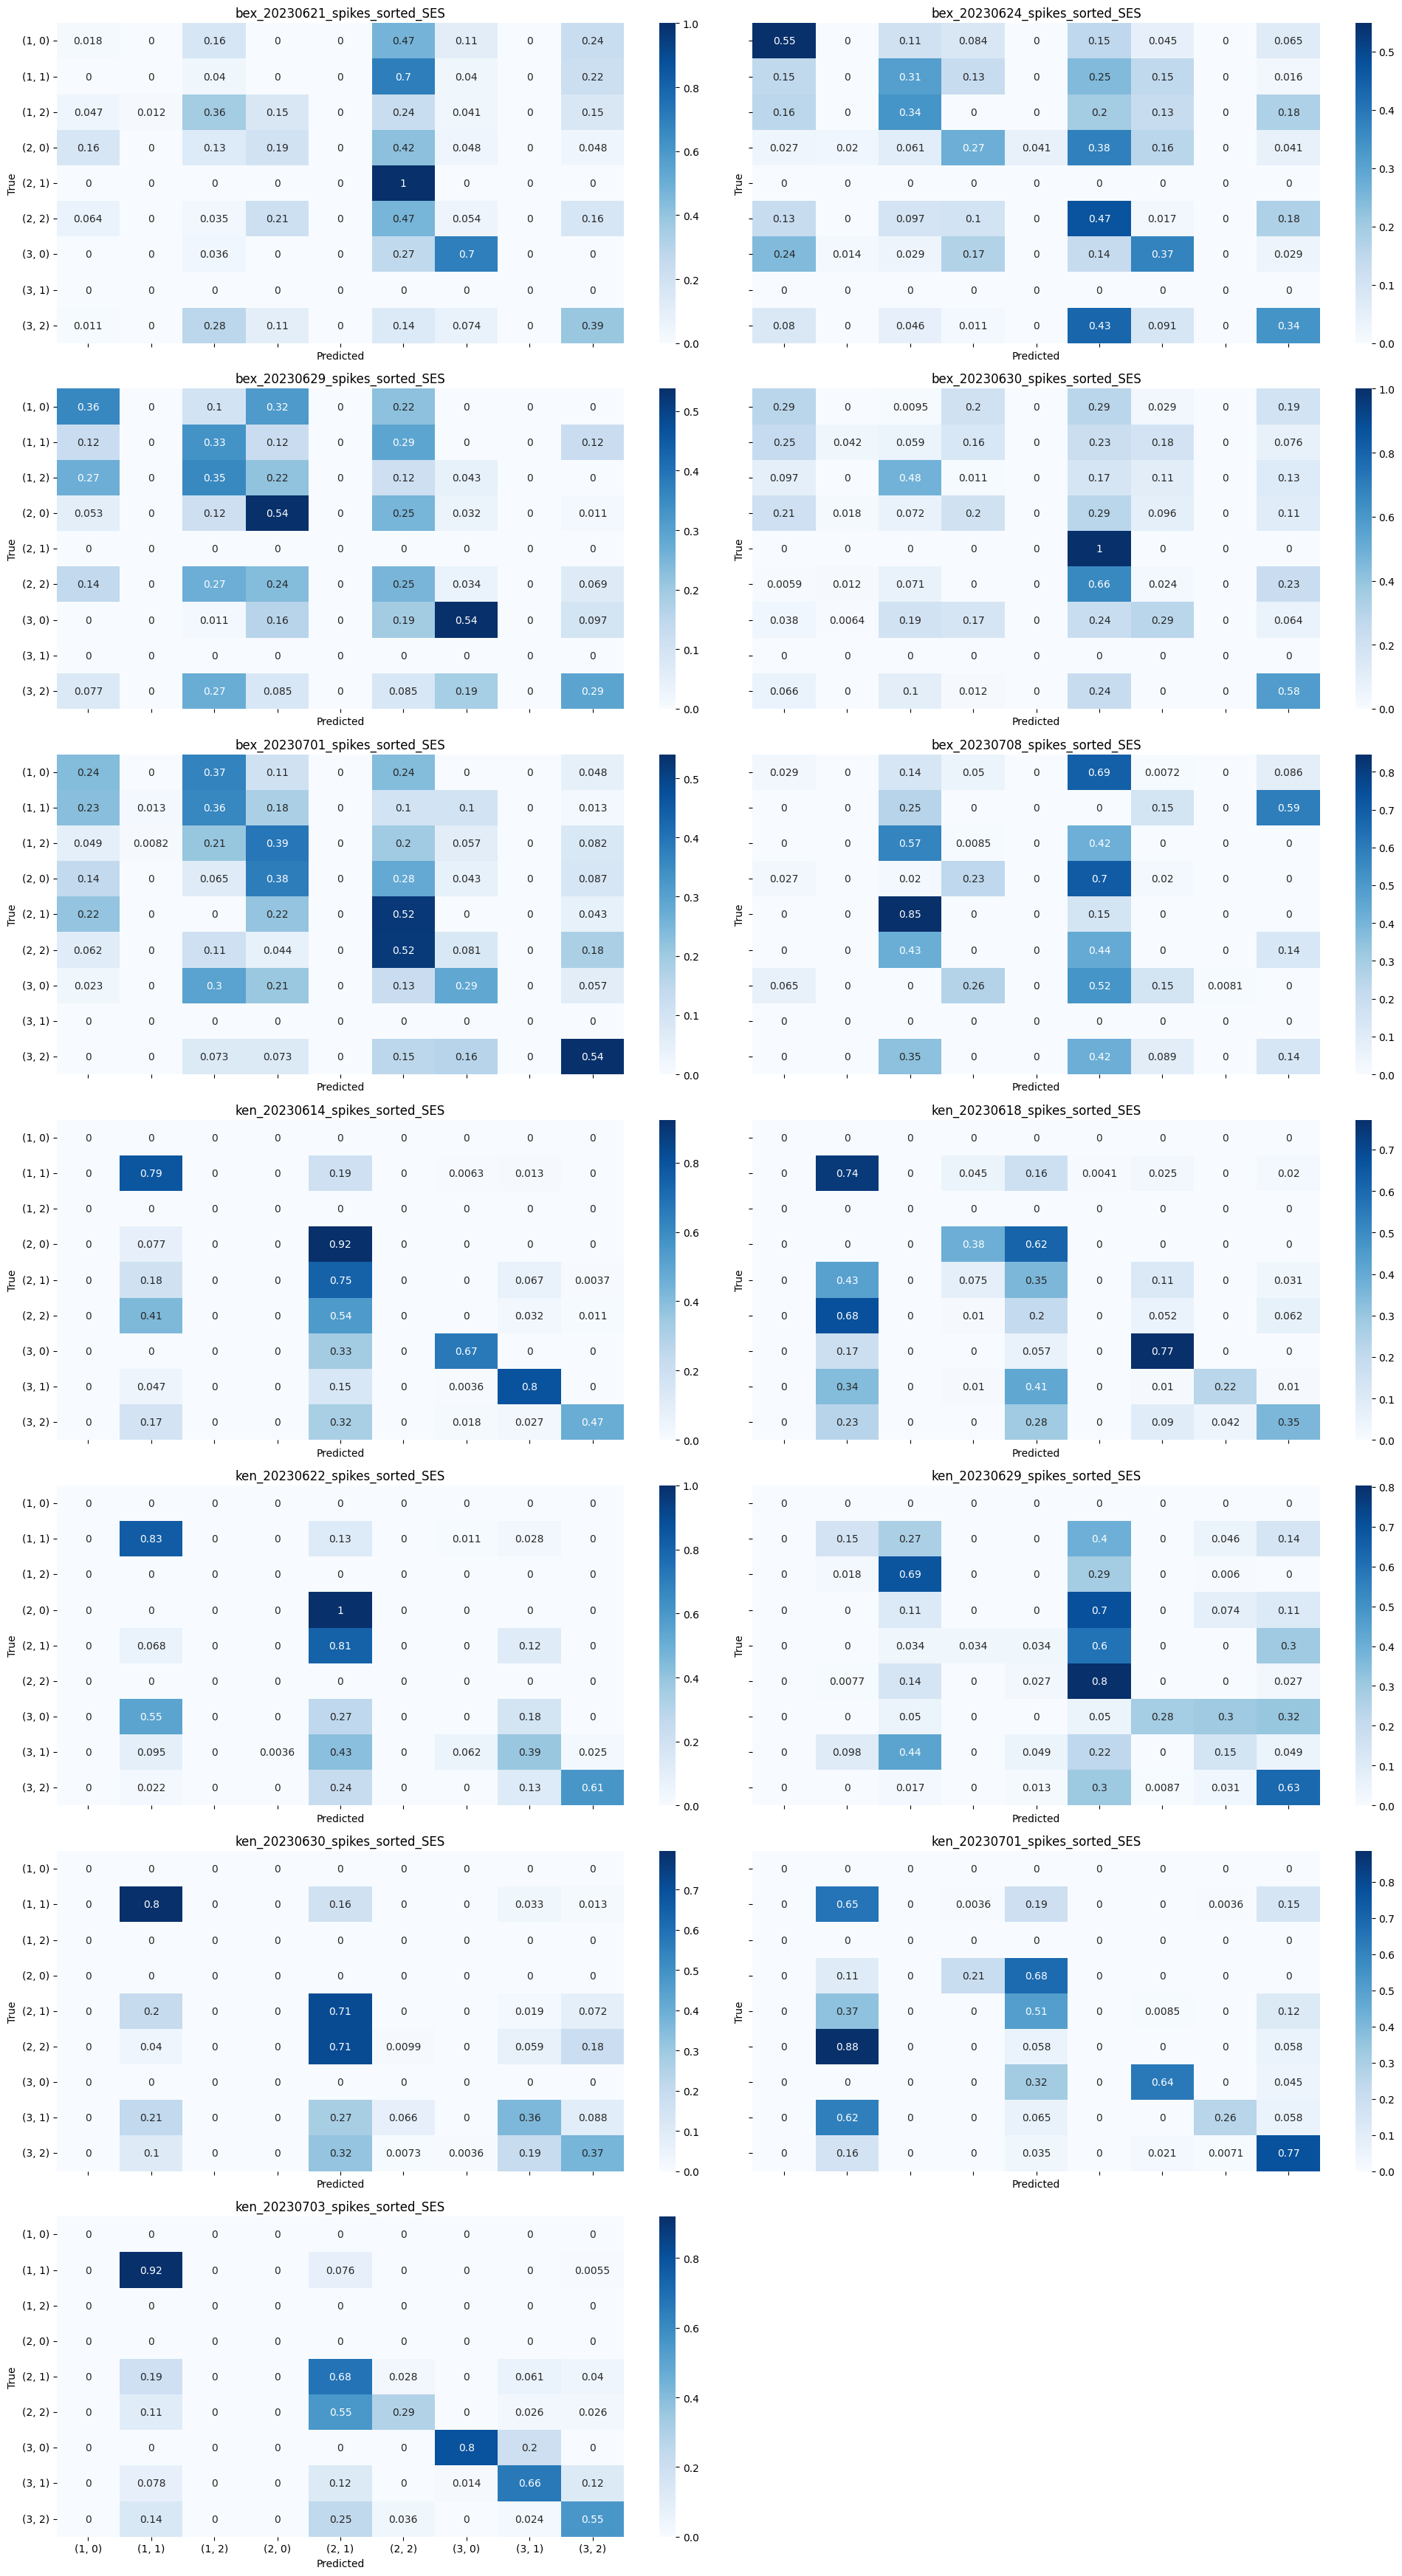

In [58]:
plot_conf_matrix(eval_gts, eval_preds, group="middle")